# Policy gradient
In policy gradient, we update arametrize directly the policy $\pi_\theta$. It's especially welcome when the action space is continuous; in that case greedy policy based on Q-learning need to compute the $argmax_a Q(s,a)$. This could be pretty tedious. More generally, policy gradient algorithms are better to explore large state-action spaces.

$J(\theta) 
= \sum_{s \in \mathcal{S}} d^\pi(s) V^\pi(s) 
= \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(a \vert s) Q^\pi(s, a)$

In discrete action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow [0,1]^{dim(A)}$ and $\forall s$ $\sum \pi_\theta(s) = 1$.

In continous action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow \mu^{dim(A)} \times \sigma^{dim(A)} =  \mathbb{R}^{dim(A)} \times \mathbb{R}_{+,*}^{dim(A)}$



It is possible to show that the loss for discrete action ($1,...,N$) with softmax policy is weighted negative binary crossentropy:
$-G\sum_{j=1}^N[a^j\log(\hat{a}^j) + (1-a^j)\log(1 - \hat{a}^j)]$

with:
$a^j=1$ if $a_t = j$, $0$ otherwise.

$\hat{a} = \pi_\theta(s_t)$.

$G$ is the discounted empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$ from state $s_t$ and $a_t$


It is possible to show that the loss for conitnous action ($1,...,N$) with multivariate Gaussian policy is given by:

#TODO


see https://aleksispi.github.io/assets/pg_autodiff.pdf for more explanation

# Reinforce

In [1]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
from tools import discount_cumsum

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
import tensorflow.keras.backend as K

In [5]:
class DeepAgent:                                                                                                                                                                                                
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.is_deterministic = is_deterministic                                                                                                                                                            
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
    def act(self, state):                                                                                                                                                                                   
        if self.is_deterministic:                                                                                                                                                                           
            action = np.argmax(self.policy[state])                                                                                                                                                          
        else:                                                                                                                                                                                               
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])                                                                                                              
            return action                                                                                                                                                                                       
        def train(current_state, action, reward, done):                                                                                                                                                         
            pass

In [12]:
import tensorflow.keras.backend as K

def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [23]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        
        self.model.summary()
        
        self.episode = []
        

    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(8, activation='relu')(input_state)
        x = Dense(4, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward]))
        else:
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            for i in range(len(episode)):
                Y[i, episode[i,1]] = 1
            loss = policy_gradient_loss(discounted_return)
            self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
            self.model.train_on_batch(X,Y)
            self.episode = []

    def save_model(self, path):
        self.model.save(path)

In [24]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done)
            rews.append(reward)
        rewards[i] = sum(rews)
        print('episode: {} - cum reward {}'.format(i, rewards[i]))
    return rewards

In [25]:
env = gym.make('CartPole-v0')
q_agent = ReinforceAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 1000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 10        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 11.0
episode: 1 - cum reward 22.0
episode: 2 - cum reward 14.0
episode: 3 - cum reward 13.0
episode: 4 - cum reward 15.0
episode: 5 - cum reward 48.0
episode: 6 - cum reward 15.0
episode: 7 - cum reward 32.0
episode: 8 - cum reward 33.0


episode: 240 - cum reward 54.0
episode: 241 - cum reward 41.0
episode: 242 - cum reward 22.0
episode: 243 - cum reward 21.0
episode: 244 - cum reward 27.0
episode: 245 - cum reward 27.0
episode: 246 - cum reward 35.0
episode: 247 - cum reward 37.0
episode: 248 - cum reward 26.0
episode: 249 - cum reward 27.0
episode: 250 - cum reward 30.0
episode: 251 - cum reward 44.0
episode: 252 - cum reward 38.0
episode: 253 - cum reward 23.0
episode: 254 - cum reward 149.0
episode: 255 - cum reward 90.0
episode: 256 - cum reward 32.0
episode: 257 - cum reward 51.0
episode: 258 - cum reward 38.0
episode: 259 - cum reward 27.0
episode: 260 - cum reward 137.0
episode: 261 - cum reward 29.0
episode: 262 - cum reward 75.0
episode: 263 - cum reward 36.0
episode: 264 - cum reward 80.0
episode: 265 - cum reward 34.0
episode: 266 - cum reward 108.0
episode: 267 - cum reward 31.0
episode: 268 - cum reward 31.0
episode: 269 - cum reward 77.0
episode: 270 - cum reward 111.0
episode: 271 - cum reward 55.0
epis

episode: 504 - cum reward 55.0
episode: 505 - cum reward 32.0
episode: 506 - cum reward 46.0
episode: 507 - cum reward 58.0
episode: 508 - cum reward 51.0
episode: 509 - cum reward 31.0
episode: 510 - cum reward 48.0
episode: 511 - cum reward 34.0
episode: 512 - cum reward 76.0
episode: 513 - cum reward 54.0
episode: 514 - cum reward 65.0
episode: 515 - cum reward 40.0
episode: 516 - cum reward 52.0
episode: 517 - cum reward 33.0
episode: 518 - cum reward 42.0
episode: 519 - cum reward 52.0
episode: 520 - cum reward 47.0
episode: 521 - cum reward 44.0
episode: 522 - cum reward 58.0
episode: 523 - cum reward 63.0
episode: 524 - cum reward 43.0
episode: 525 - cum reward 55.0
episode: 526 - cum reward 53.0
episode: 527 - cum reward 53.0
episode: 528 - cum reward 59.0
episode: 529 - cum reward 54.0
episode: 530 - cum reward 49.0
episode: 531 - cum reward 50.0
episode: 532 - cum reward 75.0
episode: 533 - cum reward 103.0
episode: 534 - cum reward 53.0
episode: 535 - cum reward 80.0
episode

ValueError: probabilities contain NaN

In [21]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01, memory_size = 5):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        
        self.model.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        

    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(8, activation='relu')(input_state)
        x = Dense(4, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is False:
            ;
        else:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            for i in range(len(episode)):
                Y[i, episode[i,1]] = 1
            if len(self.episodes) == self.memory_size:
                episodes = np.asarray(self.episodes)
                self.episodes = []
                Xs = np.vstack(episodes[:,0])
                Ys = np.vstack(episodes[:,1])
                discounted_returns = np.hstack(episodes[:,2])
                loss = policy_gradient_loss(discounted_returns)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
            else:
                self.episodes.append((X,Y,discounted_return))

    def save_model(self, path):
        self.model.save(path)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 14.0
episode: 1 - cum reward 14.0
episode: 2 - cum reward 19.0
episode: 3 - cum reward 12.0
episode: 4 - cum reward 19.0
episode: 5 - cum reward 25.0
episode: 6 - cum reward 15.0
episode: 7 - cum reward 15.0
episode: 8 - cum reward 24.0


episode: 239 - cum reward 200.0
episode: 240 - cum reward 200.0
episode: 241 - cum reward 200.0
episode: 242 - cum reward 191.0
episode: 243 - cum reward 149.0
episode: 244 - cum reward 134.0
episode: 245 - cum reward 200.0
episode: 246 - cum reward 200.0
episode: 247 - cum reward 51.0
episode: 248 - cum reward 200.0
episode: 249 - cum reward 200.0
episode: 250 - cum reward 141.0
episode: 251 - cum reward 200.0
episode: 252 - cum reward 110.0
episode: 253 - cum reward 171.0
episode: 254 - cum reward 157.0
episode: 255 - cum reward 121.0
episode: 256 - cum reward 88.0
episode: 257 - cum reward 32.0
episode: 258 - cum reward 167.0
episode: 259 - cum reward 124.0
episode: 260 - cum reward 161.0
episode: 261 - cum reward 200.0
episode: 262 - cum reward 126.0
episode: 263 - cum reward 44.0
episode: 264 - cum reward 60.0
episode: 265 - cum reward 56.0
episode: 266 - cum reward 118.0
episode: 267 - cum reward 200.0
episode: 268 - cum reward 200.0
episode: 269 - cum reward 94.0
episode: 270 - 

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

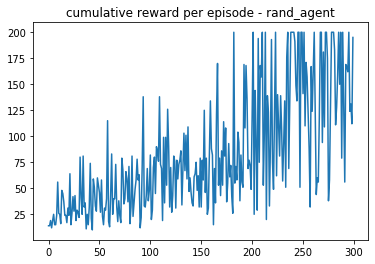

In [22]:
env = gym.make('CartPole-v0')
q_agent = ReinforceAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')